In [26]:
#matplotlib inline
from __future__ import print_function
import sys

import numpy as np
import random as rand
from numpy import sin,cos
import matplotlib.pyplot as plt
import libstempo as T
import libstempo.plot as LP
import libstempo.toasim as LT
from libstempo.libstempo import GWB
from scipy.stats import pearsonr
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS

In [27]:
print("Python version   :",sys.version.split()[0])
print("libstempo version:",T.__version__)
print("Tempo2 version   :",T.libstempo.tempo2version())

Python version   : 3.9.12
libstempo version: 2.4.4
Tempo2 version   : 2022.1.1


/var/folders/cw/yj7cg7r13h30xxtwqt8pxsrc0000gs/T/ipykernel_8567/2975463369.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  print("Tempo2 version   :",T.libstempo.tempo2version())


In [28]:
# Helper functions
def par_writer(basename,string):
    output = "MODE 1\n"
    output += "PSR\t" + basename + "\n" + "PEPOCH\t50000.0\n"
    output += string
    output += f"\nRAJ\t{basename[1:3]}:{basename[3:5]}:00\t1\nDECJ\t{basename[5]}{basename[6:8]}:{basename[8:]}:00\t1"
    with open(basename+".par",'w') as FILE:
        FILE.write(output)
        
def tim_writer(basename, tstart, tend, toaerror=0.1):
    psr = LT.fakepulsar(parfile=basename+".par",
                        obstimes=np.arange(tstart,tend,14.0)+np.random.normal(0,1),  # observe every 14+-1 days
                        toaerr=toaerror) #toaerr gives the error bars

    LT.add_efac(psr,efac=1.0,seed=1234) #adds the corresponding scatter (multiplied by 1)
    psr.savetim(basename+".tim")
    
def PulsarDistMaker(Npulsars, seed = None, disttype = 'uniform'):
    '''
    This function creates a population of random pulsars distributed uniformly in the sky. The coordinates are reported in the Geocentric-true-ecliptic frame.

    :param: Npulsars: Number of pulsars to make
    :param: seed: sets the seed for the random number generator
    :param: skyplot: if set to true, a sky plot of the pulsar population will be displayed.
    :output: lam, beta, pname: Geocentric-true-ecliptic longitude, latitude, and pulsar names (if name is set to true)

    Author: Nima Laal
    '''
    if seed: np.random.seed(seed)
    if disttype == 'uniform':c = 2
    else: c = 1
    dec = np.arcsin(np.random.uniform(-1,1, size = Npulsars))
    ra = np.random.uniform(0, c*np.pi, size = Npulsars)

    x = np.cos(ra) * np.cos(dec)
    y = np.sin(ra) * np.cos(dec)
    z = np.sin(dec)
    pos_vec = np.column_stack((x, y, z))

    sc = SkyCoord(ra = ra , dec = dec, unit = 'rad', frame='icrs')
    lam = sc.geocentrictrueecliptic.lon.deg
    beta = sc.geocentrictrueecliptic.lat.deg

    pname = []
    for ii in range(Npulsars):
        coo = ICRS(ra[ii]*u.rad, dec[ii]*u.rad)
        to_replace = ['h','m','s']
        ra_coo = coo.ra.to_string(u.hourangle)
        dec_coo = coo.dec.to_string(u.hourangle)
        for tr in to_replace:
            ra_coo = ra_coo.replace(tr, ':')
            dec_coo = dec_coo.replace(tr, ':')

        dec_str = dec_coo.split(':')
        ra_str = ra_coo.split(':')
        if len(ra_str[0]) == 1:
            ra_str[0] = '0' + ra_str[0]

        if float(dec_str[0]) < 0 or dec_str[0] == '-0':
            pname.append("J" + ra_str[0] + ra_str[1] + dec_str[0] + dec_str[1])
        else:
            pname.append("J" + ra_str[0] + ra_str[1] + "+" +  dec_str[0] + dec_str[1])

    return pname
    
def HD (angle):
    return 3/2*( (1/3 + ((1-np.cos(angle))/2) * (np.log((1-np.cos(angle))/2) - 1/6)))


In [29]:
pulsarname=PulsarDistMaker(Npulsars=50, seed = 1234, disttype = 'uniform')

In [30]:
for ii in pulsarname:
    par_writer(ii,"F0\t"+str(200*rand.uniform(0,1)+100))
    tim_writer(ii, 53000,68000)

In [31]:
psrlist=[T.tempopulsar(parfile=ii+'.par',timfile=ii+".tim") for ii in pulsarname]

/var/folders/cw/yj7cg7r13h30xxtwqt8pxsrc0000gs/T/ipykernel_8567/2663728759.py:1: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psrlist=[T.tempopulsar(parfile=ii+'.par',timfile=ii+".tim") for ii in pulsarname]


In [32]:
gwb = GWB(2000, -1234, 1e-9, 1e-6, 5e-15, -0.66, True)
for psr in psrlist:
    gwb.add_gwb(psr,1)

In [33]:
angles = []
corr = []

for ii in range(len(psrlist)):
    ra1, dec1 = psrlist[ii]['RAJ'].val, np.pi/2 - psrlist[ii]['DECJ'].val
    p1 = np.array([sin(dec1)*cos(ra1), sin(dec1)*sin(ra1), cos(dec1)])
    for jj in range(ii+1, len(psrlist)):
        ra2, dec2 = psrlist[jj]['RAJ'].val, np.pi/2 - psrlist[jj]['DECJ'].val
        p2 = np.array([sin(dec2)*cos(ra2), sin(dec2)*sin(ra2), cos(dec2)])
        
        ang = np.arccos(np.dot(p1,p2))*180/np.pi
        
        angles.append(ang)
        
        r,p = pearsonr(psrlist[ii].residuals(), psrlist[jj].residuals())
        
        corr.append(r)
        

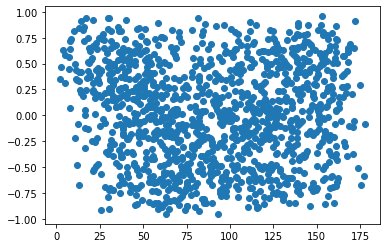

In [34]:
angles = np.array(angles)
corr = np.array(corr)
ang_argsort = np.argsort(angles)
angles = angles[ang_argsort]
corr = corr[ang_argsort]
plt.scatter(angles, corr)
plt.show()

In [35]:
print(len(angles))

1225


In [36]:
ang_reshaped = np.reshape(angles[:11000],(-1,49))
corr_reshaped = np.reshape(corr[:11000],(-1,49))

/var/folders/cw/yj7cg7r13h30xxtwqt8pxsrc0000gs/T/ipykernel_8567/2264763600.py:67: RuntimeWarning: divide by zero encountered in log
  return 3/2*( (1/3 + ((1-np.cos(angle))/2) * (np.log((1-np.cos(angle))/2) - 1/6)))
/var/folders/cw/yj7cg7r13h30xxtwqt8pxsrc0000gs/T/ipykernel_8567/2264763600.py:67: RuntimeWarning: invalid value encountered in multiply
  return 3/2*( (1/3 + ((1-np.cos(angle))/2) * (np.log((1-np.cos(angle))/2) - 1/6)))


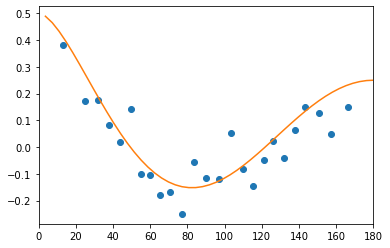

In [37]:
ang_bin = []
corr_bin = []
for ii in range(len(ang_reshaped)):
    ang_bin.append(np.mean(ang_reshaped[ii]))
    corr_bin.append(np.mean(corr_reshaped[ii]))

angs = np.linspace(0, 180, 50)
hd = HD(angs*np.pi/180)
    
plt.plot(ang_bin, corr_bin, 'o')
plt.plot(angs,hd)
plt.xlim(0,180)
plt.show()